# Implementing Matplotlib and Seaborn on the New York City Database

<b> Use pandas to read both CSV files </b>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
sns.set()

In [3]:
p_ny = pd.read_csv('Datasets/acs2017/pny.csv')
p_ny.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2017000000050,2,1,902,1,36,1011189,122,72,...,34,117,128,113,215,136,222,119,116,194
1,P,2017000000050,2,2,902,1,36,1011189,118,72,...,30,125,129,105,182,113,194,105,125,204
2,P,2017000000068,2,1,4002,1,36,1011189,56,31,...,50,60,16,15,17,63,97,54,17,61
3,P,2017000000068,2,2,4002,1,36,1011189,58,28,...,56,58,16,15,19,59,97,60,15,58
4,P,2017000000085,2,1,3803,1,36,1011189,111,54,...,35,29,39,128,211,38,101,114,99,137


In [4]:
h_ny = pd.read_csv('Datasets/acs2017/hny.csv')
h_ny.head()

,RT,SERIALNO,DIVISION,PUMA,REGION,ST,ADJHSG,ADJINC,WGTP,NP,...,WGTP71,WGTP72,WGTP73,WGTP74,WGTP75,WGTP76,WGTP77,WGTP78,WGTP79,WGTP80
0,H,2017000000046,2,4008,1,36,1000000,1011189,347,0,...,387,619,594,551,349,104,357,578,344,590
1,H,2017000000050,2,902,1,36,1000000,1011189,122,2,...,34,116,128,113,215,137,221,118,116,195
2,H,2017000000068,2,4002,1,36,1000000,1011189,56,2,...,50,61,17,15,17,62,97,54,17,61
3,H,2017000000085,2,3803,1,36,1000000,1011189,111,2,...,35,29,40,128,211,37,102,114,99,137
4,H,2017000000092,2,3701,1,36,1000000,1011189,204,0,...,398,328,187,214,66,59,353,216,218,61


<b> Use the given PUMA (public use microdata area code based on the 2010 census definition, which are areas with populations of 100k or more) ranges to further divide the dataset into NYC districts </b>

In [5]:
# PUMA ranges
bronx = [3701, 3710]
manhatten = [3801, 3810]
staten_island = [3901, 3903]
brooklyn = [4001, 4018]
queens = [4101, 4114]
nyc = [bronx[0], queens[1]]

In [6]:
def puma_filter(data, puma_ranges):
    return data.loc[(data['PUMA'] >= puma_ranges[0]) & (data['PUMA'] <= puma_ranges[1])]

h_bronx = puma_filter(h_ny, bronx)
h_manhatten = puma_filter(h_ny, manhatten)
h_staten_island = puma_filter(h_ny, staten_island)
h_brooklyn = puma_filter(h_ny, brooklyn)
h_queens = puma_filter(h_ny, queens)
p_nyc = puma_filter(p_ny, nyc)
h_nyc = puma_filter(h_ny, nyc)

<b> Create the weighted_median function in the following code to compute the median </b>

In [7]:
# Function for a 'weighted' median
def weighted_frequency(values, weights):
    weighted_values = []
    for value, weight in zip(values, weights):
        weighted_values.extend(np.repeat(value, weight))
    return weighted_values

def weighted_median(values, weights):
    return np.median(weighted_frequency(values, weights))

<b> Create a plot containing multiple subplots that visualize information with regard to NYC wages </b>

In [8]:
# Median household income in the US
us_income_median = 60336

# Data wrangling for median household income
income_adjustement = h_ny.loc[0, ['ADJINC']].values[0] / 1e6

def median_household_income(data):
    query = data.loc[np.isfinite(data['HINCP']), ['HINCP', 'WGTP']].values
    return np.round(weighted_median(query[:, 0], query[:, 1]) * income_adjustement)

In [9]:
h_ny_income_median = median_household_income(h_ny)
h_nyc_income_median = median_household_income(h_nyc)
h_bronx_income_median = median_household_income(h_bronx)
h_manhatten_income_median = median_household_income(h_manhatten)
h_staten_island_income_median = median_household_income(h_staten_island)
h_brooklyn_income_median = median_household_income(h_brooklyn)
h_queens_income_median = median_household_income(h_queens)

<b> Compute the average wage by gender for the given occupation categories for the population of NYC </b>

In [10]:
occ_categories = ['Management,\nBusiness,\nScience,\nand Arts\nOccupations', 'Service\nOccupations',
                'Sales and\nOffice\nOccupations', 'Natural Resources,\nConstruction,\nand Maintenance\nOccupations',
                'Production,\nTransportation,\nand Material Moving\nOccupations']
occ_ranges = {'Management, Business, Science, and Arts Occupations': [10, 3540], 'Service Occupations': [3600, 4650],
                'Sales and Office Occupations': [4700, 5940], 'Natural Resources, Construction, and Maintenance Occupations': [6000, 7630],
                'Production, Transportation, and Material Moving Occupations': [7700, 9750]}

In [11]:
def wage_by_gender_and_occupation(data, gender):
    weighted_wages = []
    for occ in occ_ranges.values():
        query = data.loc[(data['OCCP'] >= occ[0]) & 
        (data['OCCP'] <= occ[1]) & (data['SEX'] == gender), ['WAGP', 'PWGTP']]
        weight_sum = np.sum(query['PWGTP'])
        weighted_wages.append(np.round(np.sum(query['WAGP'] * (query['PWGTP'] / weight_sum))))
    return weighted_wages

In [12]:
wages_male = wage_by_gender_and_occupation(p_nyc, 1)
wages_female = wage_by_gender_and_occupation(p_nyc, 2)

<b> Compute the wage frequencies for New York and NYC </b>

In [13]:
wage_bins = {'<$10k': [0, 10000], '$10-20k': [10000, 20000], '$20-30k': [20000, 30000], '$30-40k': [30000, 40000], '$10-20k': [40000, 50000],
            '$50-60k': [50000, 60000], '$60-70k': [60000, 70000], '$70-80k': [70000, 80000], '$80-90k': [80000, 90000], '$90-100k': [90000, 100000],
            '$100-150k': [100000, 150000], '$150-200k': [150000, 200000], '>$200k': [200000, np.infty]}

In [14]:
def wage_frequency(data):
    valid = data.loc[np.isfinite(data['WAGP']) & (data['WAGP'] > 0), ['WAGP', 'PWGTP']] # Only consider people who have a job: salary > 0
    overall_sum = np.sum(valid['PWGTP'].values)
    frequency = []
    for wage_bin in wage_bins.values():
        query = data.loc[(data['WAGP'] * income_adjustement > wage_bin[0]) & (data['WAGP'] * income_adjustement <= wage_bin[1]), ['PWGTP']].values
        frequency.append(np.sum(query) / overall_sum)
    return frequency

In [15]:
wages_nyc = wage_frequency(p_nyc)
wages_ny = wage_frequency(p_ny)

<b> Create a plot containing multiple subplots that visualize information with regard to NYC wages </b>

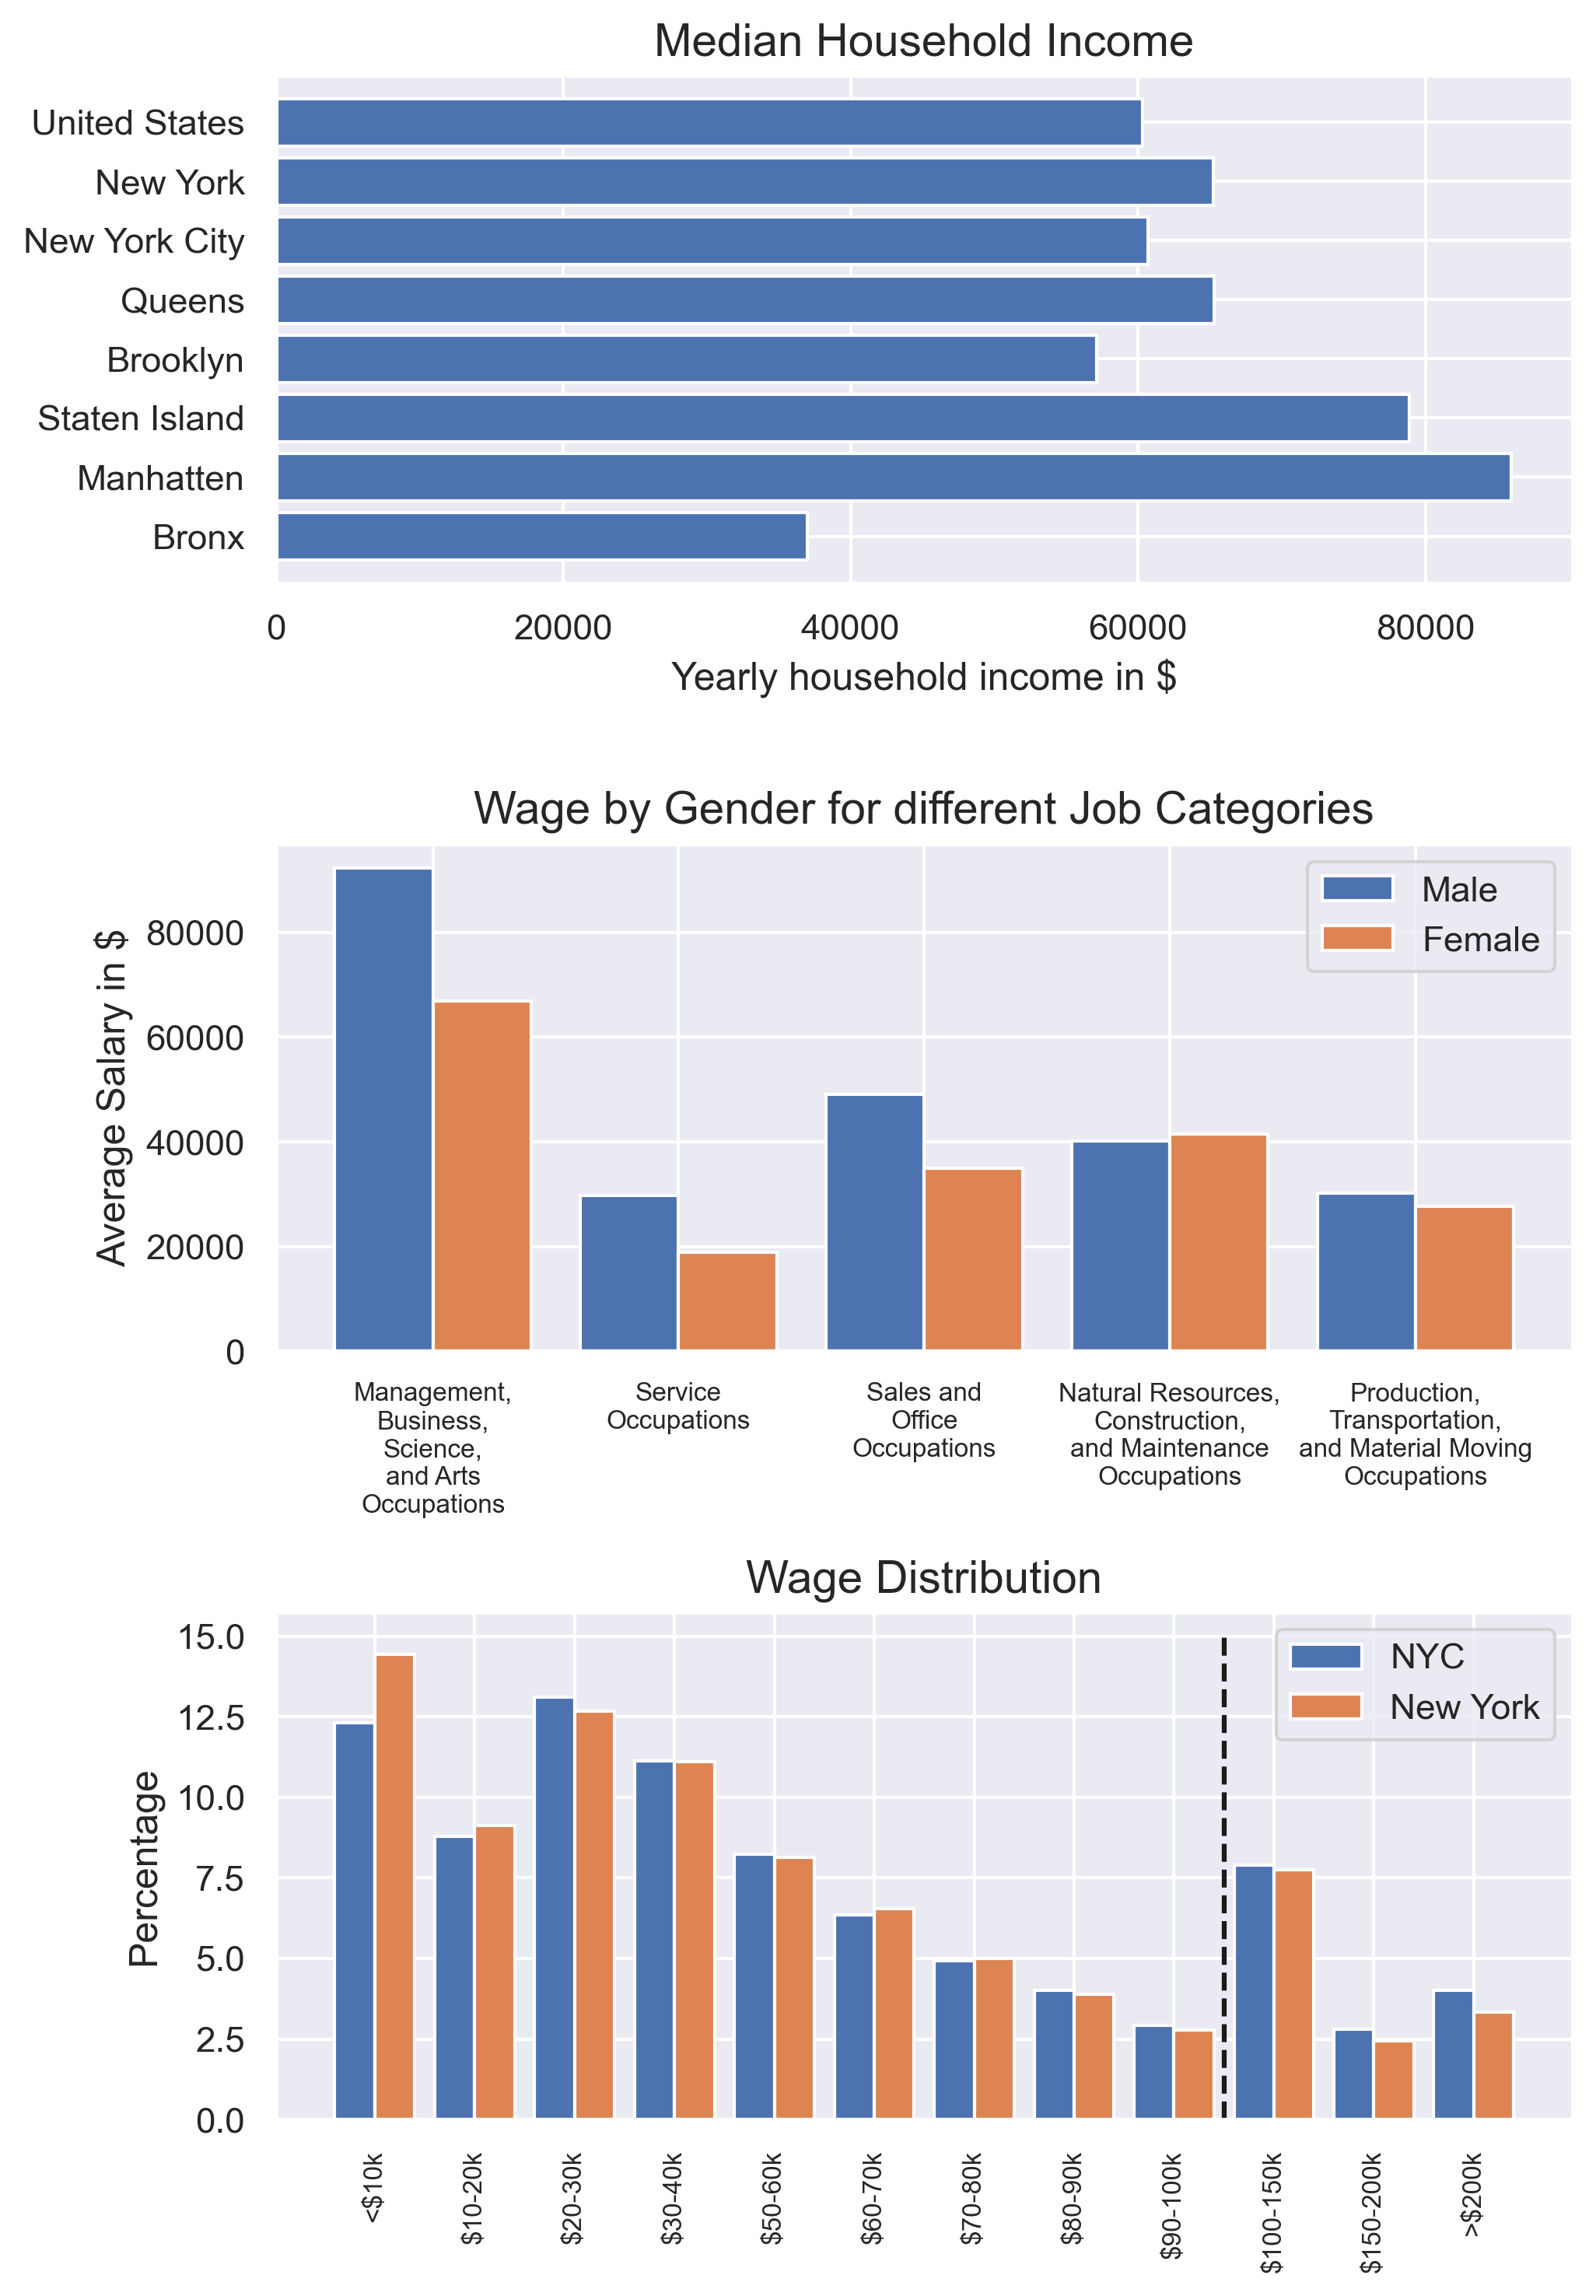

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 10), dpi=300)
# Median household income
ax1.set_title('Median Household Income', fontsize=14)
x = np.arange(8)
ax1.barh(x, [h_bronx_income_median, h_manhatten_income_median,
            h_staten_island_income_median, h_brooklyn_income_median, h_queens_income_median,
            h_nyc_income_median, h_ny_income_median, us_income_median])
ax1.set_yticks(x)
ax1.set_yticklabels(['Bronx', 'Manhatten', 'Staten Island', 'Brooklyn', 'Queens', 'New York City', 'New York', 'United States'])
ax1.set_xlabel('Yearly household income in $')
# Wage by gender in common jobs
ax2.set_title('Wage by Gender for different Job Categories', fontsize=14)
x = np.arange(5) + 1
width = 0.4
ax2.bar(x - width / 2, wages_male, width=width, label='Male')
ax2.bar(x + width / 2, wages_female, width=width, label='Female')
ax2.legend()
ax2.set_xticks(x)
ax2.set_xticklabels(occ_categories, rotation=0, fontsize=8)
ax2.set_ylabel('Average Salary in $')
# Wage distribution
ax3.set_title('Wage Distribution', fontsize=14)
x = np.arange(len(wages_nyc)) + 1
width = 0.4
ax3.bar(x - width / 2, np.asarray(wages_nyc) * 100, width=width, label='NYC')
ax3.bar(x + width / 2, np.asarray(wages_ny) * 100, width=width, label='New York')
ax3.legend()
ax3.set_xticks(x)
ax3.set_xticklabels(wage_bins.keys(), rotation=90, fontsize=8)
ax3.set_ylabel('Percentage')
ax3.vlines(x=9.5, ymin=0, ymax=15, linestyle='--')
# Overall figure
fig.tight_layout()
plt.show()

<b> Use a tree map to visualize the percentage for the given occupation subcategories for the population of NYC </b>

In [17]:
occ_subcategories = {'Management,\nBusiness,\nand Financial': [10, 950],
                    'Computer, Engineering,\nand Science': [1000, 1965],
                    'Education,\nLegal,\nCommunity Service,\nArts,\nand Media': [2000, 2960],
                    'Healthcare\nPractitioners\nand\nTechnical': [3000, 3540],
                    'Service': [3600, 4650],
                    'Sales\nand Related': [4700, 4965],
                    'Office\nand Administrative\nSupport': [5000, 5940],
                    '': [6000, 6130],
                    'Construction\nand Extraction': [6200, 6940],
                    'Installation,\nMaintenance,\nand Repair': [7000, 7630],
                    'Production': [7700, 8965],
                    'Transportation\nand Material\nMoving': [9000, 9750]}

In [18]:
def occupation_percentage(data):
    percentages = []
    overall_sum = np.sum(data.loc[(data['OCCP'] >= 10) & (data['OCCP'] <= 9750), ['PWGTP']].values)
    for occ in occ_subcategories.values():
        query = data.loc[(data['OCCP'] >= occ[0]) & (data['OCCP'] <= occ[1]), ['PWGTP']].values
        percentages.append(np.sum(query) / overall_sum)
    return percentages

In [19]:
occ_percentages = occupation_percentage(p_nyc)

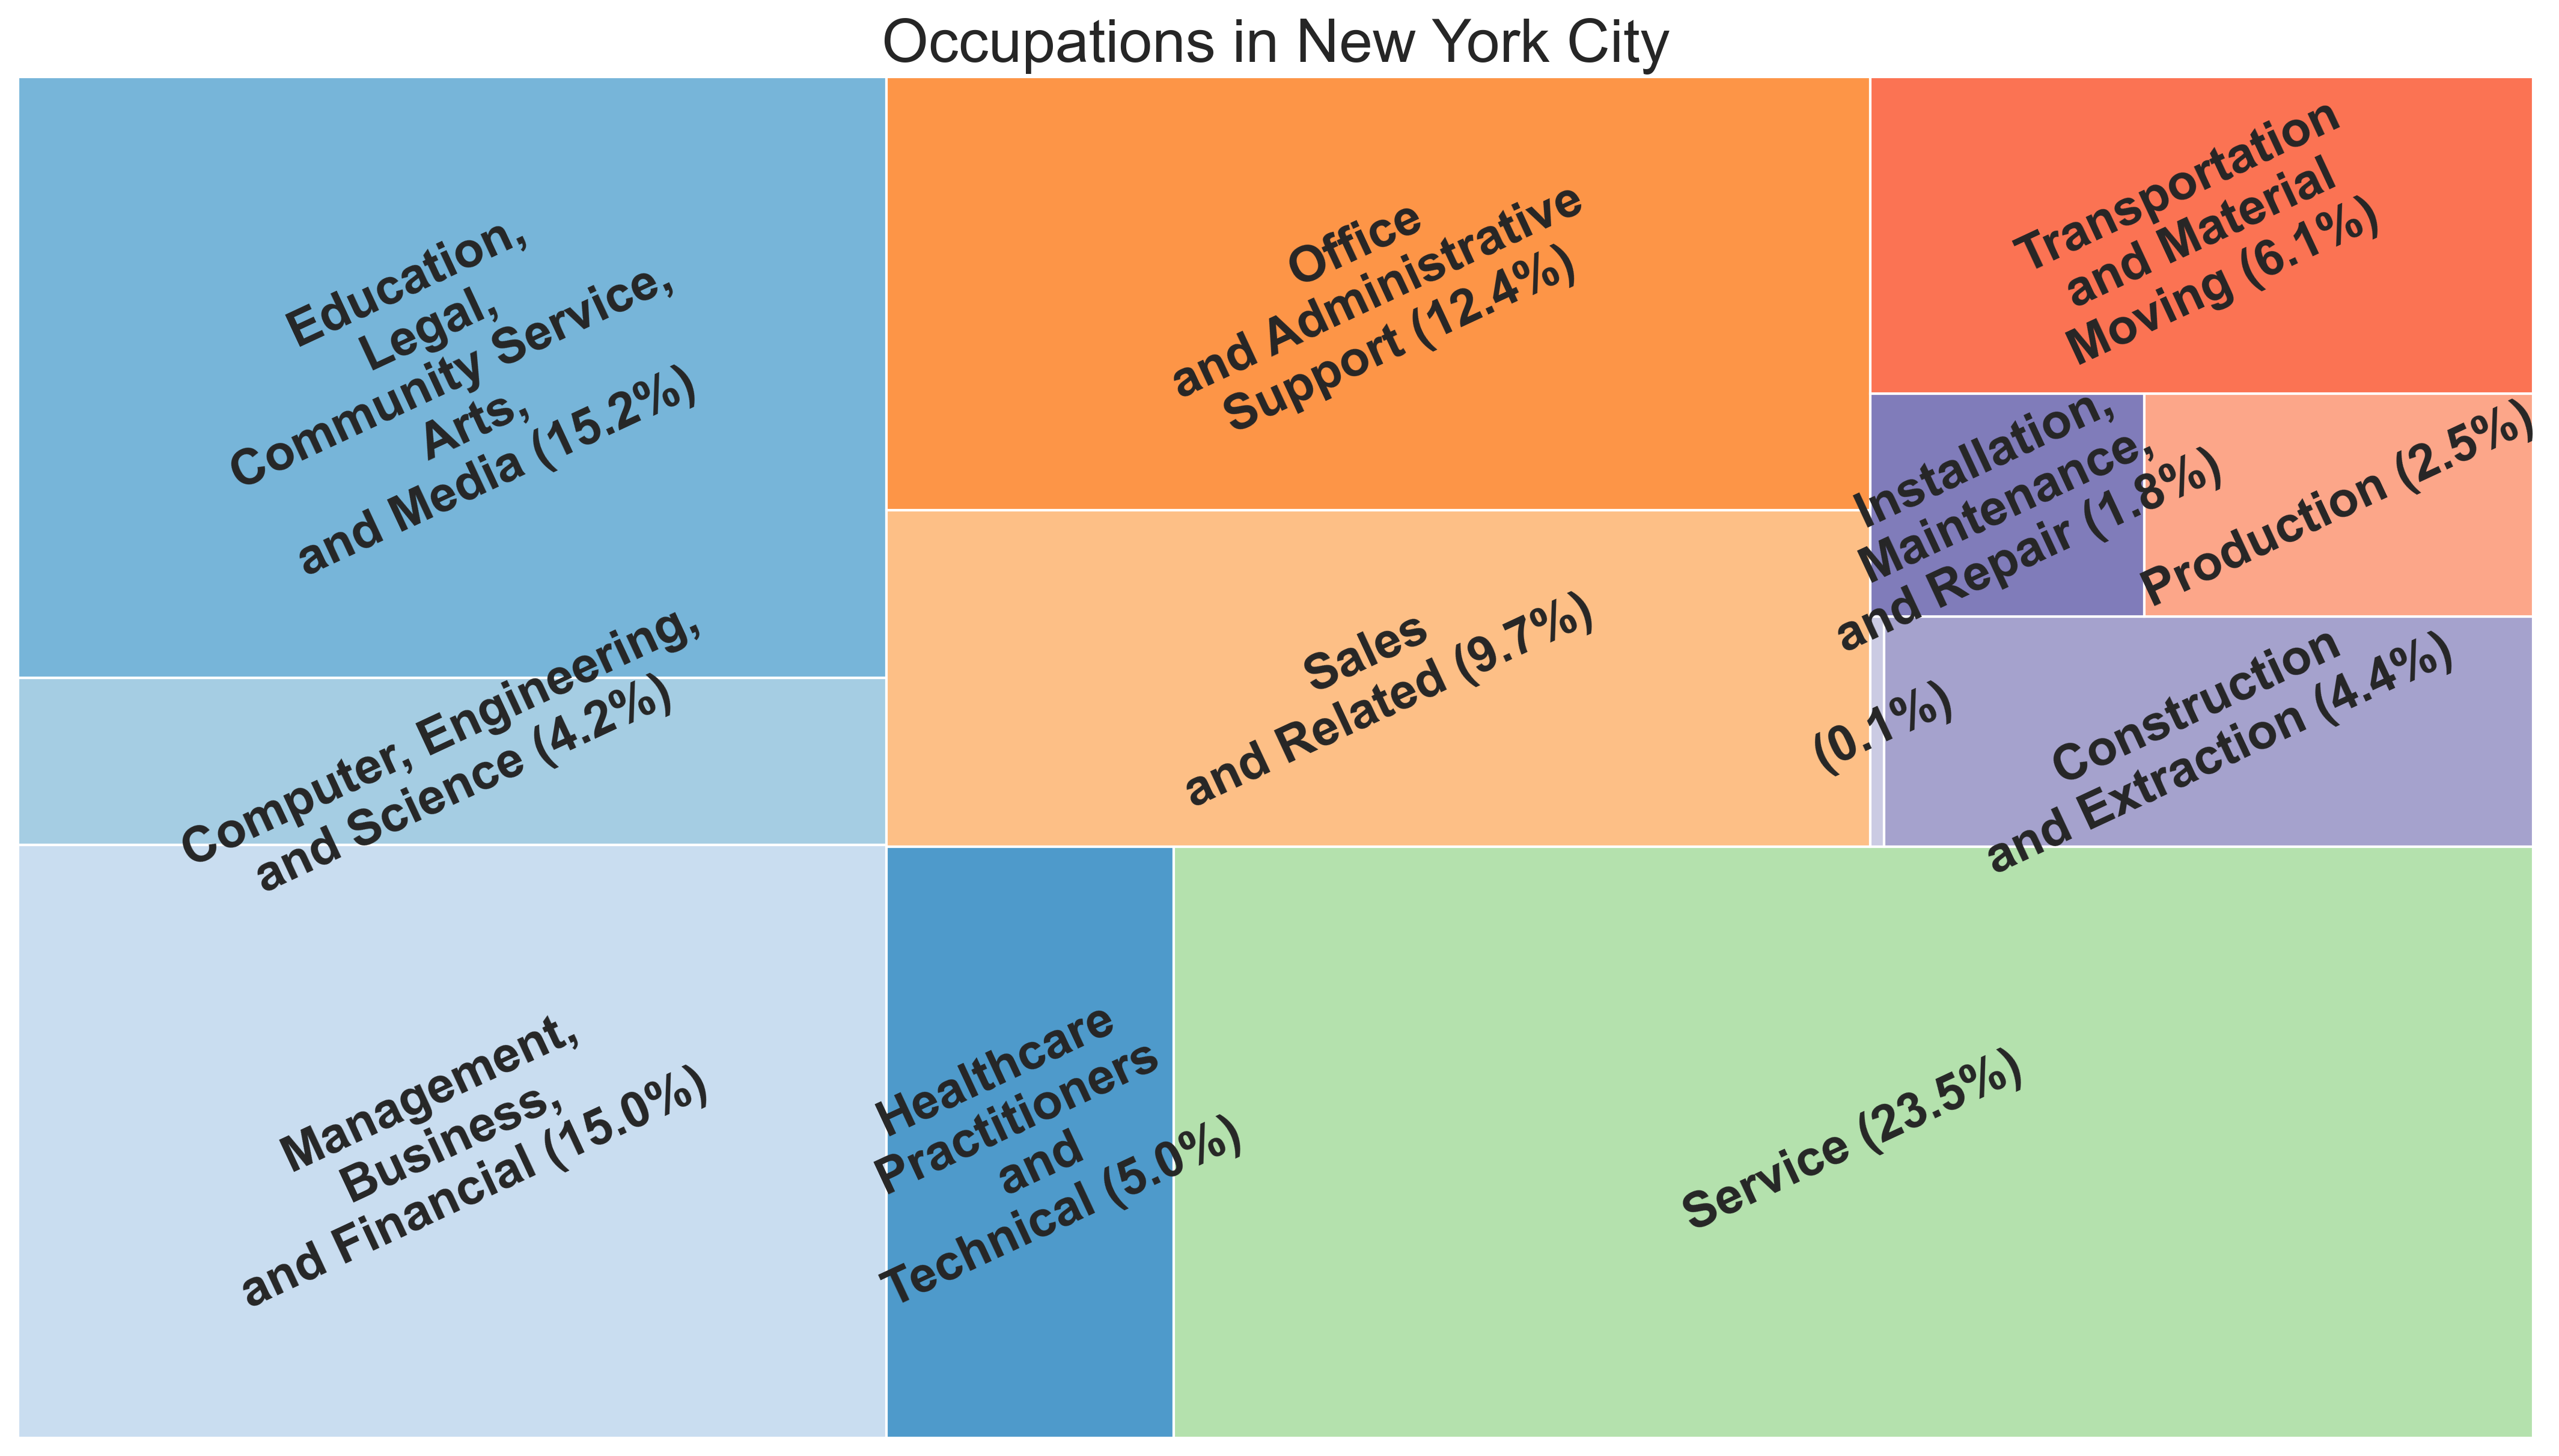

In [20]:
plt.figure(figsize=(18, 10), dpi=300)
df = pd.DataFrame({'percentage': occ_percentages, 'group': list(occ_subcategories.keys())})
df['group'] = df['group'] + ' (' + (np.round(df['percentage'] * 1000) / 10).astype('str') + '%)'
blues = [matplotlib.cm.Blues((i + 2) * 30) for i in range(4)]
greens = [matplotlib.cm.Greens((i + 2) * 40) for i in range(1)]
oranges = [matplotlib.cm.Oranges((i + 2) * 40) for i in range(2)]
purples = [matplotlib.cm.Purples((i + 2) * 40) for i in range(3)]
reds = [matplotlib.cm.Reds((i + 2) * 40) for i in range(2)]
colors = blues + greens + oranges + purples + reds
squarify.plot(sizes=df['percentage'], label=df['group'], color=colors, text_kwargs={'fontsize': 20, 'rotation': 25, 'fontweight': 'bold'})
plt.axis('off')
plt.title('Occupations in New York City', fontsize=24)
plt.savefig('tree_map.png', dpi=300, bbox_inches='tight')

<b> Use a heatmap to show the correlation between difficulties and age groups in NYC </b>

In [21]:
difficulties = {'Self-care difficulty': 'DDRS', 'Hearing difficulty': 'DEAR',
                'Vision difficulty': 'DEYE', 'Independent living difficulty': 'DOUT',
                'Ambulatory difficulty': 'DPHY', 
                'Veteran service connected disability': 'DRATX',
                'Cognitive difficulty': 'DREM'}

age_groups = {'<5': [0, 4], '5-11': [5, 11], '12-14': [12, 14], '15-17': [15, 17],
              '18-24': [18, 24], '25-34': [25, 34], '35-44': [35, 44], '45-54': [45, 54],
              '55-64': [55, 64], '65-74': [65, 74], '75+': [75, np.infty]}

In [22]:
def difficulty_age_array(data):
    array = np.zeros((len(difficulties.values()), len(age_groups.values())))
    for d, diff in enumerate(difficulties.values()):
        for a, age in enumerate(age_groups.values()):
            age_sum = np.sum(data.loc[(data['AGEP'] >= age[0]) & (data['AGEP'] <= age[1]), ['PWGTP']].values)
            query = data.loc[(data['AGEP'] >= age[0]) & (data['AGEP'] <= age[1]) & (data[diff] == 1), ['PWGTP']].values
            array[d, a] = np.sum(query) / age_sum
    return array

In [23]:
array = difficulty_age_array(p_nyc)

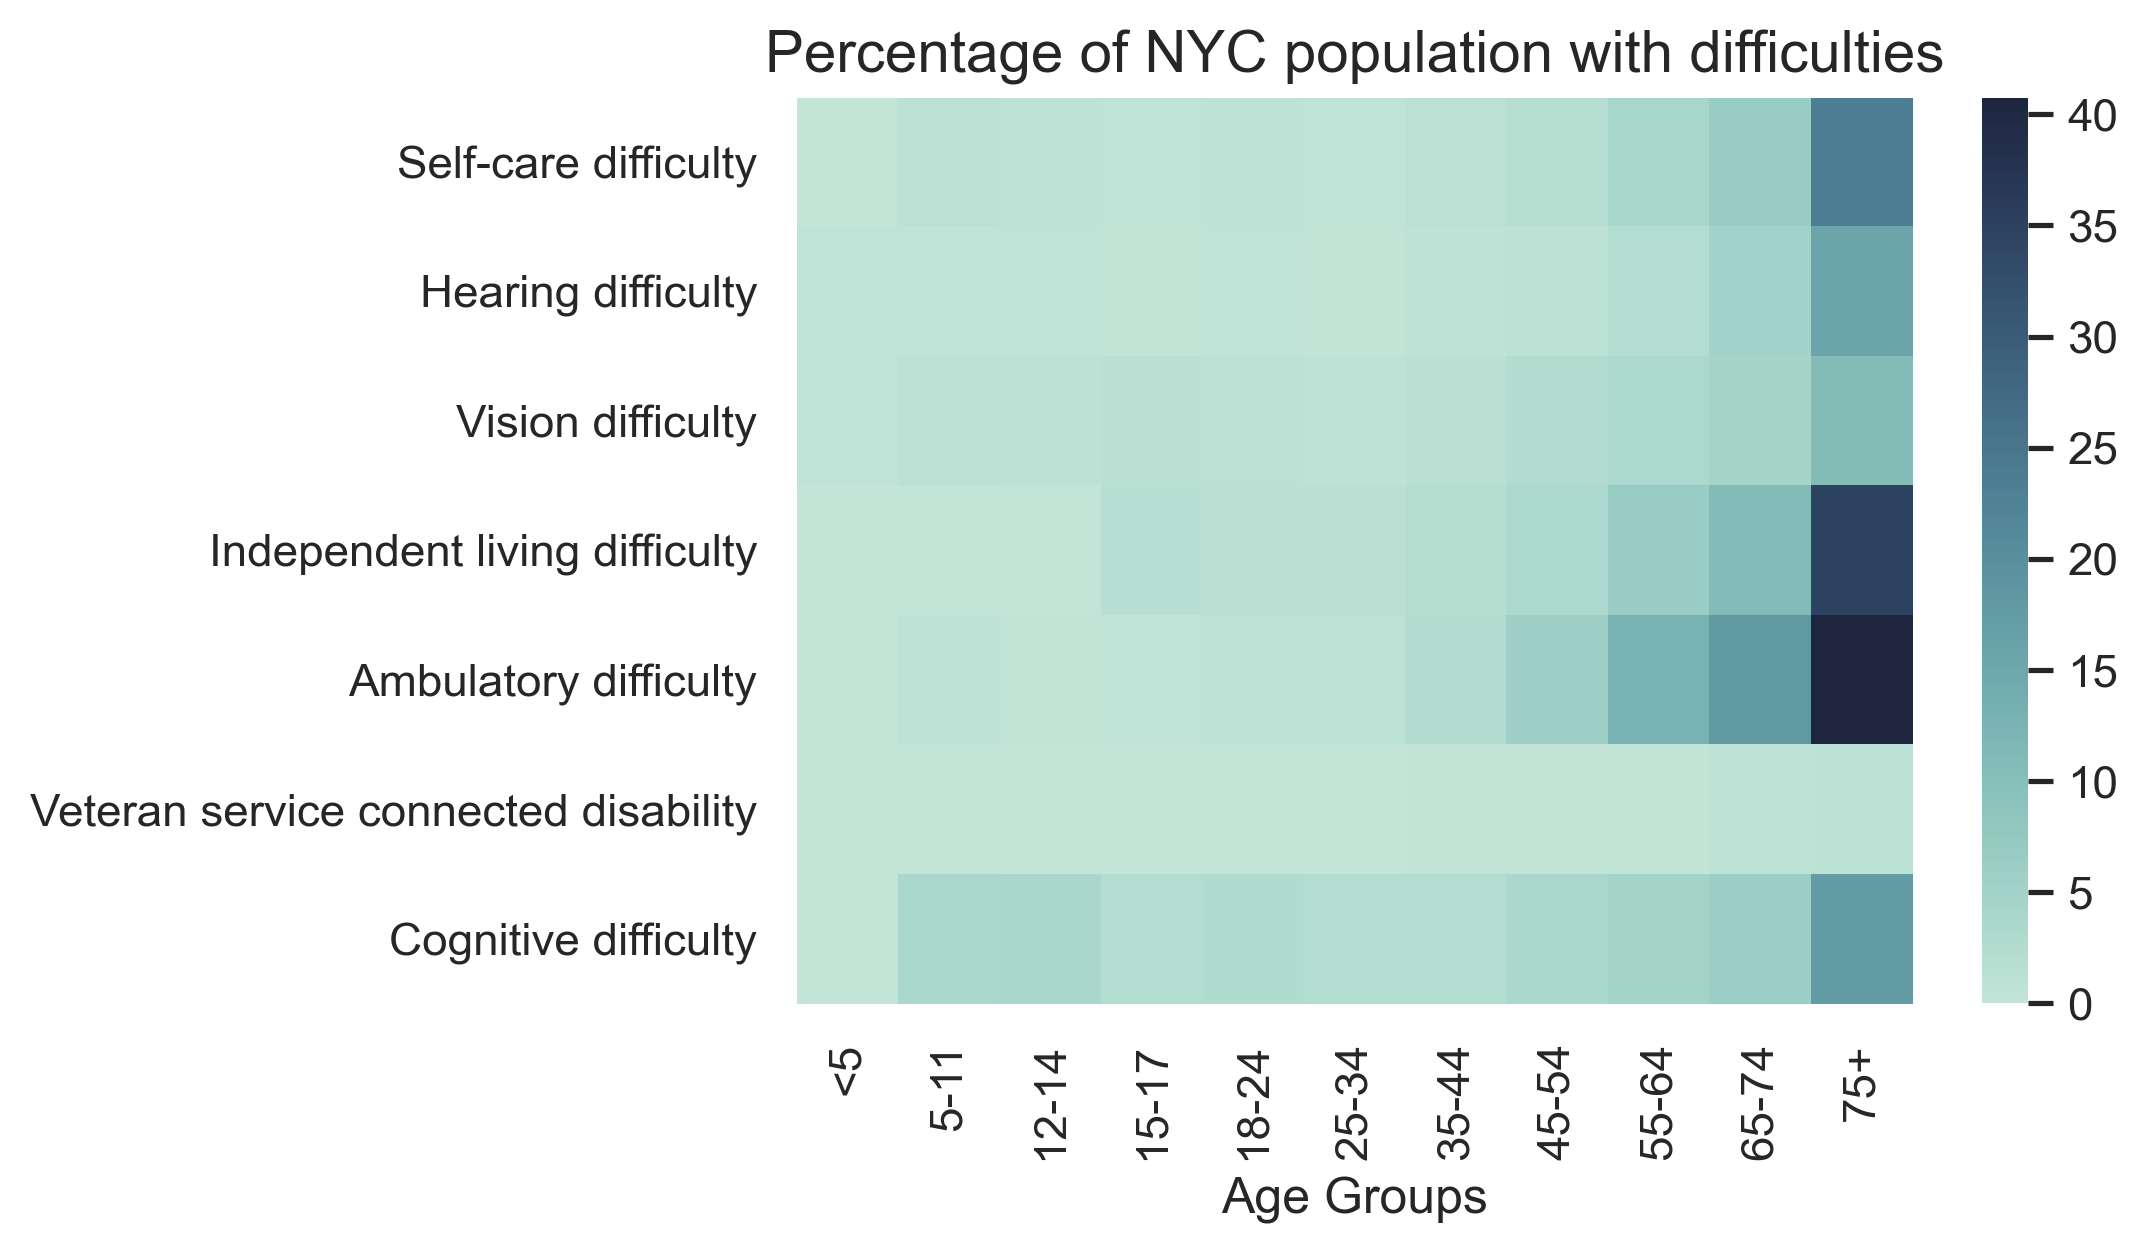

In [24]:
plt.figure(dpi=300)
ax = sns.heatmap(array * 100, cmap=sns.cubehelix_palette(rot=-.3, as_cmap=True))
ax.set_yticklabels(difficulties.keys(), rotation=0)
ax.set_xticklabels(age_groups.keys(), rotation=90)
ax.set_xlabel('Age Groups')
ax.set_title('Percentage of NYC population with difficulties', fontsize=14)
plt.show()

# Visualizing Stock Prices with Bokeh

<b> Import pandas and enable notebook output by using the bokeh.io interface </b>

In [25]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

<b> Load the downloaded stock_prices dataset </b>

In [26]:
df = pd.read_csv('Datasets/stock_prices.csv')
df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


<b> Use the datetime library to create a column, short_date, in our DataFrame that holds the information from the date column without the hour, minute, and second information </b>

In [27]:
from datetime import datetime

def shorten_time_stamp(timestamp):
    shortened = timestamp[0] 
    if len(shortened) > 10:
        parsed_date = datetime.strptime(shortened, '%Y-%m-%d %H:%M:%S')
        shortened = datetime.strftime(parsed_date, '%Y-%m-%d') 
    return shortened

df['short_date'] = df.apply(lambda x: shorten_time_stamp(x), axis=1)

<b> Validate by displaying the first five elements of the updated DataFrame </b>

In [28]:
df.head()

,date,symbol,open,close,low,high,volume,short_date
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0,2016-01-05
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0,2016-01-06
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0,2016-01-07
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0,2016-01-08
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0,2016-01-11


<b> Import figure and show from Bokeh and interact and widgets from ipywidgets to get started </b>

In [29]:
from bokeh.plotting import figure, show
from ipywidgets import interact, widgets

<b> Get the unique stock names from the dataset. Filter out the dates from 2016. Create a list that contains the strings open-close and volume, which will be used for the radio buttons to switch between the two plots </b>

In [30]:
stock_names = df['symbol'].unique()
dates_2016 = df[df['short_date'] >= '2016-01-01']['short_date']
unique_dates_2016 = sorted(dates_2016.unique())
value_options = ['open-close', 'volume']

<b> After extracting the necessary data, set up the interaction elements. Create widgets for the following: a dropdown for the first stock name and a dropdown for the second stock name that will be compared to the first </b>

In [31]:
drp_1 = widgets.Dropdown(options=stock_names,
                         value='AAPL',
                         description='Compare:')

drp_2 = widgets.Dropdown(options=stock_names,
                         value='AON',
                         description='to:')

<b> Set up a SelectionRangeSlider to select the range of dates we want to display in our plot </b>

In [32]:
range_slider = widgets.SelectionRangeSlider(options=unique_dates_2016,
                                            index=(0,25),
                                            continuous_update=False,
                                            description='From-To',
                                            layout={'width': '500px'})

<b> Define a RadioButtons attribute to choose between the candlestick plot and the plot that displays the traded volume </b>

In [33]:
value_radio = widgets.RadioButtons(options=value_options,
                                   value='open-close',
                                   description='Metric')

<b> Set up the @interact method that finally displays the complete visualization </b>

In [34]:
@interact(stock_1=drp_1, stock_2=drp_2, date=range_slider, value=value_radio)
def get_stock_for_2016(stock_1, stock_2, date, value):
    show(get_plot(stock_1, stock_2, date, value))

interactive(children=(Dropdown(description='Compare:', index=4, options=('WLTW', 'A', 'AAL', 'AAP', 'AAPL', 'A…

<b> Start with the so-called candlestick visualization, which is often used with stock price data. Calculate the mean for every (high/low) pair and then plot those data points with a line with the given color. Next, set up an add_candle_plot that gets a plot object, a stock_name, a stock_range columns containing the data of only the selected date range that was defined with the widgets, and a color for the line. Create a segment that creates the vertical line, and either a green or red vbar to color code whether the close price is lower than the open price. Once the candles are created, draw a continuous line running through the mean high, low point of each candle </b>

In [35]:
def add_candle_plot(plot, stock_name, stock_range, color):
    
    inc_1 = stock_range.close > stock_range.open
    dec_1 = stock_range.open > stock_range.close
    w = 0.5
    
    plot.segment(stock_range['short_date'],
                 stock_range['high'],
                 stock_range['short_date'],
                 stock_range['low'],
                 color="grey")
    
    plot.vbar(stock_range['short_date'][inc_1], w,
              stock_range['high'][inc_1],
              stock_range['close'][inc_1],
              fill_color="green",
              line_color="black",
              legend_label=('Mean price of ' + stock_name))
    
    plot.vbar(stock_range['short_date'][dec_1], w,
              stock_range['high'][dec_1],
              stock_range['close'][dec_1],
              fill_color="red",
              line_color="black",
              legend_label=('Mean price of ' + stock_name))
    
    stock_mean_val=stock_range[['high', 'low']].mean(axis=1)
    
    plot.line(stock_range['short_date'],
              stock_mean_val,
              legend_label=('Mean price of ' + stock_name),
              line_color=color, alpha=0.5)

<b> Move on and implement the line plot in the cell that contains the get_plot method. Plot a line for the data from stock_1 with a blue color. Plot a line for the data from stock_2 with an orange color </b>

In [36]:
def get_plot(stock_1, stock_2, date, value):
    
    stock_1 = df[df['symbol'] == stock_1]
    stock_2 = df[df['symbol'] == stock_2]
    
    stock_1_name = stock_1['symbol'].unique()[0]
    stock_1_range = stock_1[(stock_1['short_date'] >= date[0]) & (stock_1['short_date'] <= date[1])]
    stock_2_name = stock_2['symbol'].unique()[0]
    stock_2_range = stock_2[(stock_2['short_date'] >= date[0]) & (stock_2['short_date'] <= date[1])]

    plot = figure(title='Stock prices', 
                     x_axis_label='Date', 
                     x_range=stock_1_range['short_date'], 
                     y_axis_label='Price in $USD',
                     plot_width=800, 
                     plot_height=500)
    
    plot.xaxis.major_label_orientation = 1
    plot.grid.grid_line_alpha=0.3
    
    if value == 'open-close':
        add_candle_plot(plot, stock_1_name, stock_1_range, 'blue')
        add_candle_plot(plot, stock_2_name, stock_2_range, 'orange')
    if value == 'volume':
        plot.line(stock_1_range['short_date'],
                  stock_1_range['volume'],
                  legend_label=stock_1_name,
                  muted_alpha=0.2)
        plot.line(stock_2_range['short_date'],
                  stock_2_range['volume'],
                  legend_label=stock_2_name,
                  muted_alpha=0.2,
                  line_color='orange')
        plot.legend.click_policy="mute"
    return plot

In [37]:
@interact(stock_1=drp_1, stock_2=drp_2, date=range_slider, value=value_radio)
def get_stock_for_2016(stock_1, stock_2, date, value):
    show(get_plot(stock_1, stock_2, date, value))

interactive(children=(Dropdown(description='Compare:', index=4, options=('WLTW', 'A', 'AAL', 'AAP', 'AAPL', 'A…

# Analyzing Airbnb Data with Geoplotlib

<b> Import the necessary dependencies </b>

In [38]:
import geoplotlib

<b> Load the airbnb_new_york.csv dataset </b>

In [39]:
df = pd.read_csv('Datasets/airbnb_new_york_smaller.csv')
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,21456,https://www.airbnb.com/rooms/21456,20181206022948,2018-12-06,Light-filled classic Central Park,"An adorable, classic, clean, light-filled one-...","An adorable, classic, clean, light-filled one-...","An adorable, classic, clean, light-filled one-...",none,"Diverse. Great coffee shops and restaurants, n...",...,f,NaN,NaN,f,f,moderate,t,t,1,0.72
1,2539,https://www.airbnb.com/rooms/2539,20181206022948,2018-12-06,Clean & quiet apt home by the park,Renovated apt home in elevator building.,"Spacious, renovated, and clean apt home, one b...",Renovated apt home in elevator building. Spaci...,none,Close to Prospect Park and Historic Ditmas Park,...,f,NaN,NaN,f,f,moderate,f,f,8,0.25
2,21644,https://www.airbnb.com/rooms/21644,20181206022948,2018-12-06,"Upper Manhattan, New York",A great space in a beautiful neighborhood- min...,Nice room in a spacious pre-war apartment in u...,A great space in a beautiful neighborhood- min...,none,I love that the neighborhood is safe to walk a...,...,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0.51
3,3330,https://www.airbnb.com/rooms/3330,20181206022948,2018-12-06,++ Brooklyn Penthouse Guestroom ++,"This is a spacious, clean, furnished master be...","Room Features: - clean, hardwood floors - 2 la...","This is a spacious, clean, furnished master be...",none,Location is GREAT!! Right off the L train in t...,...,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,3,0.35
4,21794,https://www.airbnb.com/rooms/21794,20181206022948,2018-12-06,COZY QUIET room 4 DOOGLERS!,"It's comfy & has a loft bed & a chaise lounge,...",This is the smaller room of the two I have ava...,"It's comfy & has a loft bed & a chaise lounge,...",none,GREAT Central Location. On 15th street between...,...,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,2,0.25


<b> Since our dataset once again has columns that are named Latitude and Longitude instead of lat and lon, rename those columns to their short versions </b>

In [40]:
df['lat'] = df['latitude']
df['lon'] = df['longitude']

<b> To use a color map that changes color based on the price of accommodation </b>

In [41]:
def convert_to_float(x):
    try:
        value=str.replace(x[1:], ',', '')
        return float(value)
    except:
        return 0.0

In [42]:
df['price'] = df['price'].fillna('$0.0')
df['review_scores_rating'] = df['review_scores_rating'].fillna(0.0)
df['dollar_price'] = df['price'].apply(lambda x: convert_to_float(x))

<b> Print all the columns that are available and an example for that column to decide what information is suitable </b>

In [43]:
for col in df.columns:
    print('{}\t{}'.format(col, df[col][0]))

id	21456
listing_url	https://www.airbnb.com/rooms/21456
scrape_id	20181206022948
last_scraped	2018-12-06
name	Light-filled classic Central Park 
summary	An adorable, classic, clean, light-filled one-bedroom apartment with windows in each room that overlook the courtyards of historic row-houses.  A great retreat after a day exploring the city...and one block from lovely Central Park!  
space	An adorable, classic, clean, light-filled one-bedroom apartment with windows in each room that overlook the courtyards of historic row-houses.  A great retreat after a day exploring the city...and one block from lovely Central Park! There is a livingroom/diningroom with a comfy click-clack futon couch that folds into a queen-size bed, and a separate, light-filled bedroom with a full-size bed.   The apartment has a complete, yet small kitchen and a clean bathroom with a bathtub.  Hot water is plentiful, the toilet well-functioning! It is a 3rd floor walk-up. (no elevator/lift) Free wireless internet.

<b> Trim down the number of columns our working dataset has by creating a subsection of the columns with id, latitude (as lat), longitude (as lon), price (in $), and review_scores_rating </b>

In [44]:
columns = ['id', 'lat', 'lon', 'dollar_price', 'review_scores_rating']
sub_data = df[columns]
sub_data.head()

,id,lat,lon,dollar_price,review_scores_rating
0,21456,40.797642,-73.961775,140.0,94.0
1,2539,40.647486,-73.972370,149.0,98.0
2,21644,40.828028,-73.947308,89.0,100.0
3,3330,40.708558,-73.942362,70.0,98.0
4,21794,40.740085,-74.002706,111.0,99.0


<b> Create a new DataAccessObject object with the newly created subsection of the dataset. Use it to plot out a dot map </b>

In [45]:
from geoplotlib.utils import DataAccessObject

data = DataAccessObject(sub_data)

geoplotlib.dot(data)
geoplotlib.show()

<b> Create a new ValueLayer class that extends the geoplotlib BaseLayer class </b>

In [46]:
import pyglet
import geoplotlib
from geoplotlib.layers import BaseLayer
from geoplotlib.core import BatchPainter
from geoplotlib.colors import ColorMap
from geoplotlib.utils import BoundingBox

In [47]:
class ValueLayer(BaseLayer):

    def __init__(self, dataset, bbox=BoundingBox.WORLD):
        # initialize instance variables
        self.data = dataset
        self.display = 'dollar_price'
        self.painter = BatchPainter()
        self.view = bbox
        self.cmap = ColorMap('jet', alpha=255, levels=100)
        
    def invalidate(self, proj):
        # paint every point with a color that represents the currently selected attributes value
        self.painter = BatchPainter()
        max_val = max(self.data[self.display])
        scale = 'log' if self.display == 'dollar_price' else 'lin'
        
        for index, id in enumerate(self.data['id']):
            # log scale can't start at 0, must be 1
            min_val = max(self.data[self.display][index], 1)
            
            color = self.cmap.to_color(min_val, max_val, scale)
            self.painter.set_color(color)
            lat, lon = self.data['lon'][index], self.data['lat'][index]
            x, y = proj.lonlat_to_screen(lat, lon)
            self.painter.points(x, y, 5)
        
    def draw(self, proj, mouse_x, mouse_y, ui_manager):
        # display the ui manager info
        ui_manager.info('Use left and right to switch between the displaying of price and ratings. Currently displaying: {}'.format(self.display))
        self.painter.batch_draw()
        
    def on_key_release(self, key, modifiers):
        # check if left or right keys are pressed to switch to other attribute
        if key == pyglet.window.key.LEFT or key == pyglet.window.key.RIGHT:
            self.display = 'dollar_price' if self.display != 'dollar_price' else 'review_scores_rating'
            return True
        return False
        
    def bbox(self):
        # bounding box that gets used when layer is created
        return self.view

<b> Create a new BoundingBox function focused on New York by using north=40.897994, west=-73.999040, south=40.595581, east=-73.95040. In addition to a custom BoundingBox, we will use the darkmatter tile </b>

In [48]:
ny_bbox = BoundingBox(north=40.897994, west=-73.999040, south=40.595581, east=-73.95040)
# displaying our custom layer using add_layer
geoplotlib.tiles_provider('darkmatter')
geoplotlib.add_layer(ValueLayer(data, bbox=ny_bbox))
geoplotlib.show()